# Polafit

## Import Package

In [1]:
import os
import cv2
import csv
import json
import shutil
import kagglehub
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


## Dataset

**1. Download dataset**

In [2]:
path = kagglehub.dataset_download("dansbecker/food-101")

print("Path to dataset files:", path)

100%|██████████| 9.38G/9.38G [08:19<00:00, 20.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1


**2. Change Path**

In [3]:
!cp -r /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1 /content/dataset

**3. Take 20 Class**

In [4]:
source_dir = '/content/dataset/food-101/food-101/images'
output_dir = '/content/dataset/food-101/food-101/subsets'

os.makedirs(output_dir, exist_ok=True)

chosen_classes = [
    'fried_rice', 'chicken_curry', 'dumplings', 'spring_rolls', 'sushi',
    'ramen', 'fried_calamari', 'hamburger', 'pizza', 'ice_cream',
    'donuts', 'chocolate_cake', 'tiramisu', 'spaghetti_bolognese',
    'pancakes', 'waffles', 'pad_thai', 'chicken_wings', 'takoyaki',
    'french_fries'
]

subset_dir = os.path.join(output_dir, 'indonesian_popular_subset')
os.makedirs(subset_dir, exist_ok=True)

for class_name in chosen_classes:
    class_path = os.path.join(source_dir, class_name)
    target_path = os.path.join(subset_dir, class_name)

    if os.path.exists(class_path):

        if os.path.exists(target_path):
            shutil.rmtree(target_path)

        shutil.copytree(class_path, target_path)
        print(f"Kelas '{class_name}' berhasil disalin.")
    else:
        print(f"Kelas '{class_name}' tidak ditemukan di direktori asal.")

print("Subset dengan kelas makanan populer selesai dibuat.")


Kelas 'fried_rice' berhasil disalin.
Kelas 'chicken_curry' berhasil disalin.
Kelas 'dumplings' berhasil disalin.
Kelas 'spring_rolls' berhasil disalin.
Kelas 'sushi' berhasil disalin.
Kelas 'ramen' berhasil disalin.
Kelas 'fried_calamari' berhasil disalin.
Kelas 'hamburger' berhasil disalin.
Kelas 'pizza' berhasil disalin.
Kelas 'ice_cream' berhasil disalin.
Kelas 'donuts' berhasil disalin.
Kelas 'chocolate_cake' berhasil disalin.
Kelas 'tiramisu' berhasil disalin.
Kelas 'spaghetti_bolognese' berhasil disalin.
Kelas 'pancakes' berhasil disalin.
Kelas 'waffles' berhasil disalin.
Kelas 'pad_thai' berhasil disalin.
Kelas 'chicken_wings' berhasil disalin.
Kelas 'takoyaki' berhasil disalin.
Kelas 'french_fries' berhasil disalin.
Subset dengan kelas makanan populer selesai dibuat.


**4. Dataset Preparation**

In [5]:
subset_dir = '/content/dataset/food-101/food-101/subsets/indonesian_popular_subset'

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
train_data = datagen.flow_from_directory(
    subset_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True,
)

val_data = datagen.flow_from_directory(
    subset_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

class_labels = train_data.class_indices
print(class_labels)

Found 16000 images belonging to 20 classes.
Found 4000 images belonging to 20 classes.
{'chicken_curry': 0, 'chicken_wings': 1, 'chocolate_cake': 2, 'donuts': 3, 'dumplings': 4, 'french_fries': 5, 'fried_calamari': 6, 'fried_rice': 7, 'hamburger': 8, 'ice_cream': 9, 'pad_thai': 10, 'pancakes': 11, 'pizza': 12, 'ramen': 13, 'spaghetti_bolognese': 14, 'spring_rolls': 15, 'sushi': 16, 'takoyaki': 17, 'tiramisu': 18, 'waffles': 19}


Check shape dataset

In [6]:
print("Images Shape:",train_data.image_shape)

Images Shape: (128, 128, 3)


In [7]:
unique_labels = np.unique(train_data.labels)

print("Labels:", unique_labels)

Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


Check dataset

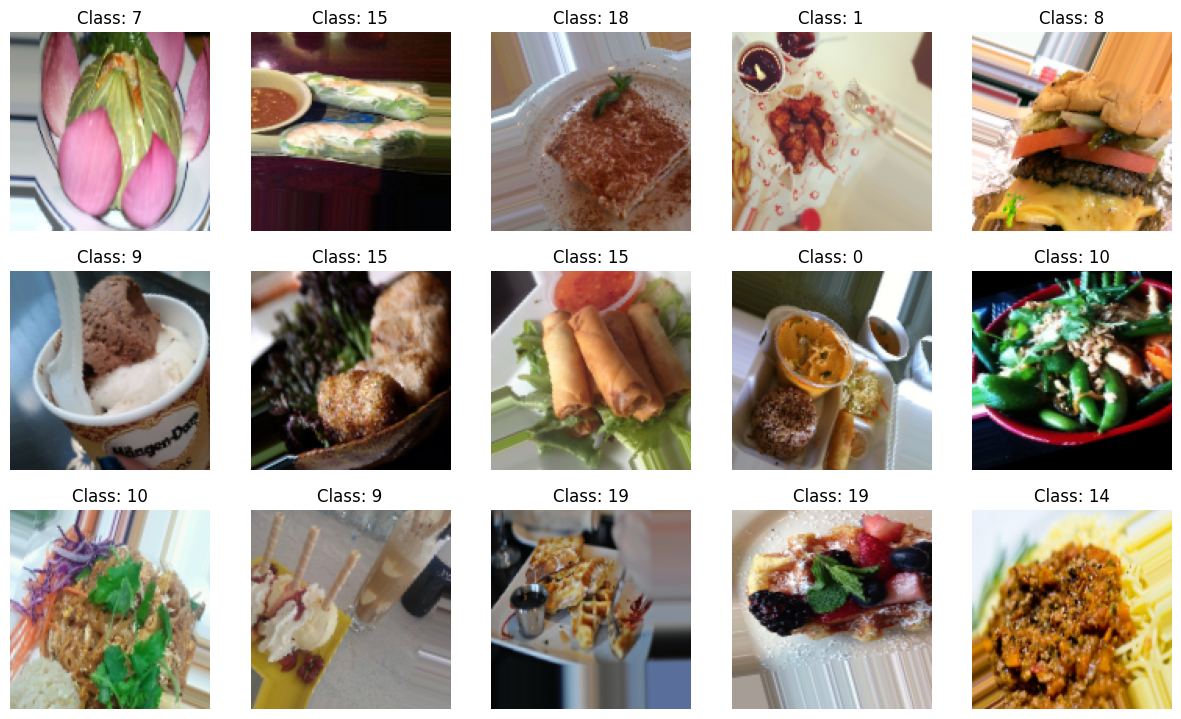

In [8]:
images, labels = next(train_data)

num_images = 15
plt.figure(figsize=(15, 15))

for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[i].argmax()}")
    plt.axis("off")

plt.show()


## Create Model

**Frist stage fine tune** : Extract feature

In [9]:
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)
base_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
model = tf.keras.models.Sequential([
    base_model,
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(20, activation='softmax')
])


model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 4, 4, 32)            │         294,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │          10,260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,441,044 (28.39 MB)

 Trainable params: 403,348 (1.54 MB)

 Non-trainable params: 7,037,696 (26.85 MB)

In [11]:
callbacks = EarlyStopping(
    patience=10,
    monitor='val_accuracy',
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

## Training (Two-stage fine-tuning)


**Feature Extraction**

In [12]:
  history = model.fit(
      train_data,
      epochs=20,
      callbacks=[callbacks, lr_scheduler],
      validation_data=val_data
    )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 176s 147ms/step - accuracy: 0.2968 - loss: 2.4616 - val_accuracy: 0.5257 - val_loss: 1.8309 - learning_rate: 0.0010
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 135s 134ms/step - accuracy: 0.5265 - loss: 1.7308 - val_accuracy: 0.5773 - val_loss: 1.5319 - learning_rate: 0.0010
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 136s 135ms/step - accuracy: 0.5631 - loss: 1.6211 - val_accuracy: 0.5995 - val_loss: 1.4964 - learning_rate: 0.0010
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 144s 137ms/step - accuracy: 0.5853 - loss: 1.5140 - val_accuracy: 0.6170 - val_loss: 1.3991 - learning_rate: 0.0010
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 136ms/step - accuracy: 0.6000 - loss: 1.4850 - val_accuracy: 0.6308 - val_loss: 1.3766 - learning_rate: 0.0010
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 137s 137ms/step - accuracy: 0.6163 - loss: 1.4385 - val_accuracy: 0.6283 - val_loss: 1.3942 - learning_rate: 0.0010
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 141s 136ms/step - acc

**Fine-Tuning**

In [13]:
# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
#Stage 2 (Fine-tune)
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 270s 158ms/step - accuracy: 0.6244 - loss: 1.3823 - val_accuracy: 0.7320 - val_loss: 0.9995
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 204s 165ms/step - accuracy: 0.7320 - loss: 1.0065 - val_accuracy: 0.7682 - val_loss: 0.9041
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 148s 148ms/step - accuracy: 0.7694 - loss: 0.8873 - val_accuracy: 0.7872 - val_loss: 0.8172
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 203s 149ms/step - accuracy: 0.7856 - loss: 0.8215 - val_accuracy: 0.7958 - val_loss: 0.7982
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 218s 165ms/step - accuracy: 0.8138 - loss: 0.7191 - val_accuracy: 0.7980 - val_loss: 0.7915
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 186s 149ms/step - accuracy: 0.8170 - loss: 0.6965 - val_accuracy: 0.8087 - val_loss: 0.7546
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 203s 151ms/step - accuracy: 0.8366 - loss: 0.6474 - val_accuracy: 0.8043 - val_loss: 0.7846
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 201s 150ms/step - ac

In [15]:
# Evaluation after fine-tuning
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Loss (Fine-Tuning): {val_loss:.4f}")
print(f"Validation Accuracy (Fine-Tuning): {val_acc:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.8031 - loss: 0.7721
Validation Loss (Fine-Tuning): 0.7466
Validation Accuracy (Fine-Tuning): 0.8125


**Plot**

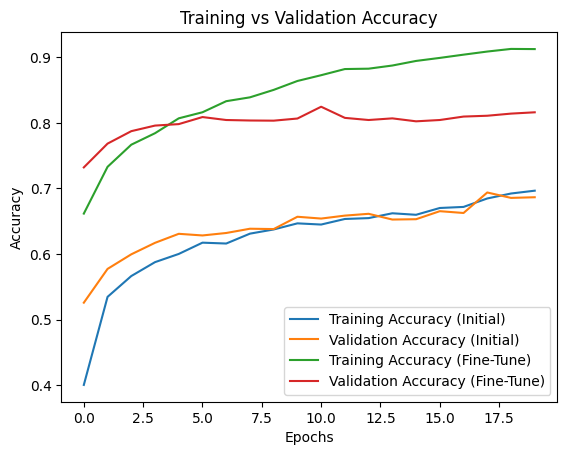

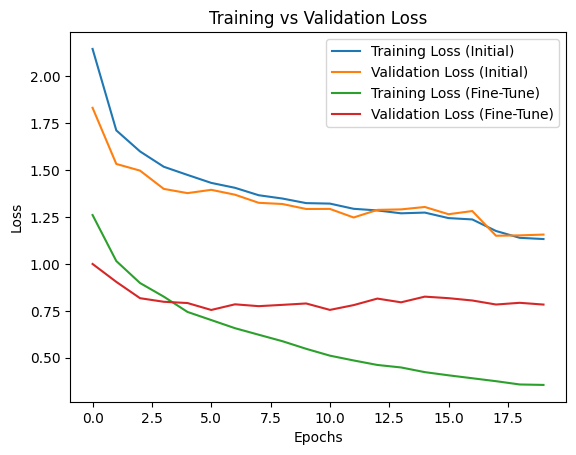

In [16]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy (Initial)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Initial)')
plt.plot(history_fine.history['accuracy'], label='Training Accuracy (Fine-Tune)')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy (Fine-Tune)')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss (Initial)')
plt.plot(history.history['val_loss'], label='Validation Loss (Initial)')
plt.plot(history_fine.history['loss'], label='Training Loss (Fine-Tune)')
plt.plot(history_fine.history['val_loss'], label='Validation Loss (Fine-Tune)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [17]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - accuracy: 0.8032 - loss: 0.7682
Val Loss: 0.7732
Val Accuracy: 0.8125


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prediksi pada validation/test data
val_preds = model.predict(val_data)
val_preds_classes = np.argmax(val_preds, axis=1)
true_classes = val_data.classes



# Classification report
print(classification_report(true_classes, val_preds_classes, target_names=val_data.class_indices.keys()))


250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step
                     precision    recall  f1-score   support

      chicken_curry       0.74      0.74      0.74       200
      chicken_wings       0.78      0.89      0.83       200
     chocolate_cake       0.81      0.77      0.79       200
             donuts       0.81      0.81      0.81       200
          dumplings       0.87      0.85      0.86       200
       french_fries       0.81      0.95      0.88       200
     fried_calamari       0.78      0.73      0.76       200
         fried_rice       0.82      0.82      0.82       200
          hamburger       0.93      0.74      0.82       200
          ice_cream       0.75      0.74      0.75       200
           pad_thai       0.82      0.80      0.81       200
           pancakes       0.77      0.78      0.78       200
              pizza       0.88      0.88      0.88       200
              ramen       0.88      0.87      0.88       200
spaghetti_bolognese       0.83      0.89

## Save Model

In [20]:
model.save('/content/model/food_20class_model.h5')

In [21]:
model = tf.keras.models.load_model('/content/model/food_20class_model.h5')

## Testing

In [24]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

uploaded = files.upload()

model = load_model('/content/model/food_20class_model.h5')

for img_name in uploaded.keys():
    img_path = img_name
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)

    predicted_class = np.argmax(prediction, axis=1)
    print(f"Predicted class: {predicted_class}")

Saving best-burger-restaurant-names.jpg to best-burger-restaurant-names.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted class: [8]


In [25]:
def get_nutrition(predicted_class):
    file_path = '/content/nutrition-20 - Sheet1 (1).csv'
    with open(file_path, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if int(row['ID']) == predicted_class:
                nutrition_info = {
                    "ID": int(row['ID']),
                    "Makanan": row['Makanan'],
                    "Berat per Serving (g)": row['Berat per Serving (g)'],
                    "Kalori (kcal)": row['Kalori (kcal)'],
                    "Protein (g)": row['Protein (g)'],
                    "Lemak (g)": row['Lemak (g)'],
                    "Karbohidrat (g)": row['Karbohidrat (g)'],
                    "Serat (g)": row['Serat (g)'],
                    "Gula (g)": row['Gula (g)']
                }
                return json.dumps(nutrition_info, indent=4)

nutrition_json = get_nutrition(predicted_class)
print(nutrition_json)

{
    "ID": 8,
    "Makanan": "Hamburger",
    "Berat per Serving (g)": "200",
    "Kalori (kcal)": "300",
    "Protein (g)": "20",
    "Lemak (g)": "18",
    "Karbohidrat (g)": "25",
    "Serat (g)": "3",
    "Gula (g)": "5"
}
